In [1]:
from classification_algorithms import classification_ranf, classification_decistree
import pandas as pd
import geopandas as gp
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

In [2]:
 !ls data/main_dataset

Variable_Codebook.docx data.csv               data_target.csv


In [3]:
X = pd.read_csv('data/main_dataset/data.csv')
y = pd.read_csv('data/main_dataset/data_target.csv', index_col=0, names=['target'])

In [4]:
# classifier doesn't support categorial data
yy = pd.DataFrame(label_binarize(y, classes=y['target'].unique()))

In [6]:
geoX = gp.GeoDataFrame(X, geometry=gp.points_from_xy(X.Longitude, X.Latitude))

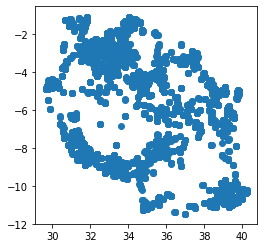

In [7]:
geoX.plot();

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=0.33, random_state=42)

In [ ]:
classification_decistree(X_train, y_train)

Fitting 10 folds for each of 998 candidates, totalling 9980 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  6.9min


In [ ]:
classification_ranf(X_train, y_train)